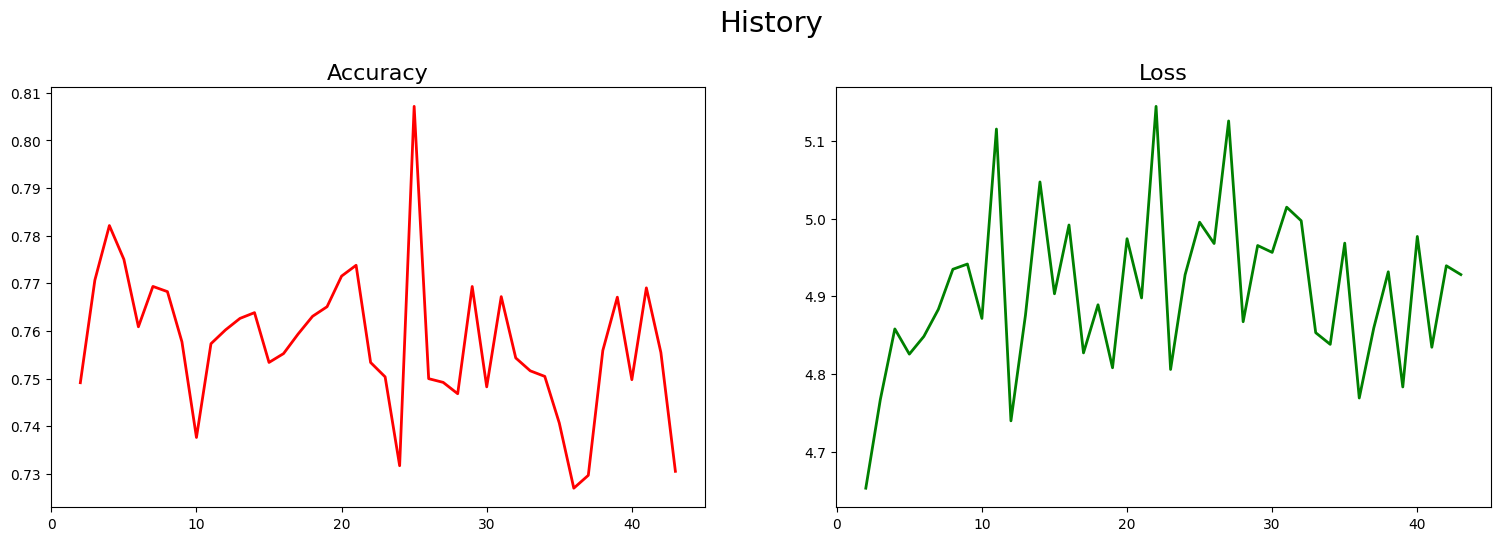

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import json

results_df = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_df['layers'] = range(2,len(results_df)+2)
results_df.to_json('model1_lyaers100.json')


with open('model1_lyaers100.json') as json_file:
    json_file = json.loads(json_file.read())
results_df = pd.DataFrame(json_file)
results_df

fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title('Accuracy', fontsize = 16, y = 1)
plt.plot(results_df['layers'], results_df['accuracy'], color='r', linewidth=2)

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title('Loss', fontsize = 16, y = 1)
plt.plot(results_df['layers'], results_df['loss'], color='g', linewidth=2)

plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()